In [1]:
import numpy as np
import osmnx as ox
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pickle
import pymde
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import spsolve, lsqr
from scipy.linalg import solve_triangular, qr
import scipy
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding

import mlrfit as mf
import lrrouting as ldr
import time, gc

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 4

mtype = "symm_small_world"
n = 5000

G = nx.connected_watts_strogatz_graph(n, k=4, p=0.01)
G.remove_edges_from(nx.selfloop_edges(G))
n = G.number_of_nodes()
G = G.to_directed()
print(f"{n=}, {G.number_of_edges()=}")

visited = []
for u, v in G.edges():
    if (u, v)in visited or (v, u) in visited: continue
    G[u][v]['weight'] = np.random.rand() * 10
    G[v][u]['weight'] = G[u][v]['weight']
    visited += [(u,v)]
del visited
Adj, Dist = ldr.nx_graph_to_matrices(G)

n=5000, G.number_of_edges()=20000
[5000]
n_cc = 5000, n0 = 5000
in  degrees: {0: 0, 1: 0, 2: 0, 3: 98, 4: 4805, 5: 96, 6: 1}
out degrees: {0: 0, 1: 0, 2: 0, 3: 98, 4: 4805, 5: 96, 6: 1}


In [4]:
# G_cc = G.subgraph(nodes_cc)
# assert nx.is_strongly_connected(G_cc)
np.histogram(Dist.flatten(), bins=5, density=True)

(array([9.94020171e-04, 6.16068659e-03, 3.69170705e-03, 3.70299103e-04,
        1.06776976e-05]),
 array([  0.        ,  89.06789071, 178.13578142, 267.20367213,
        356.27156285, 445.33945356]))

In [5]:
# fig, ax = ox.plot_graph(G, bgcolor="#ffffff", edge_color='k', edge_linewidth=0.2, node_color='k', node_size=2, figsize=(12, 12))

In [6]:
U, Vt, sigmas = mf.frob_low_rank(Dist)
frob_losses = np.zeros(n)
normalization = np.linalg.norm(Dist, ord='fro')
# assert np.allclose(normalization, ((sigmas**2).sum())**0.5)
sigmas2 = (sigmas**2)[::-1]
frob_losses = np.concatenate([(np.cumsum(sigmas2)**0.5)[::-1][1:] / normalization, np.array([0])])

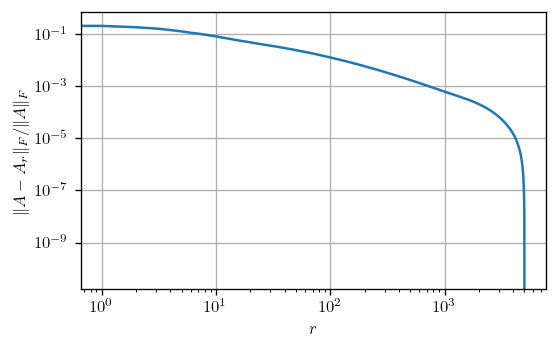

In [7]:
mf.plot_frob_error_rank(frob_losses)

In [8]:
adjacency_list = ldr.adjacency_directed_list(Adj)
sources, targets = ldr.st_pairs(n, Dist, 1020)
M = min(1000, sources.size)
sources = sources[:M]
targets = targets[:M]

graph is not directed


In [9]:
del Adj, G

In [10]:
PSD = False
w_min = Dist[Dist>0].min()
rt_max_iters = min(int(5*Dist.max()/w_min), (10**4) // 2)
symm = np.allclose(Dist, Dist.T)
print(f"{symm=}")
filename = "%s_r%d_%d"%(mtype, rank, n)

symm=True


In [11]:
info = {} 

# $\sqrt{n}$ rows and columns sampled 

In [12]:
# percentage_of_nodes = 10
# pi = np.random.permutation(n)[:int(n * percentage_of_nodes / 100.)]

pi_rows = np.random.permutation(n)[:int(np.sqrt(n))]
pi_cols = np.random.permutation(n)[:int(np.sqrt(n))]

rDist = Dist[pi_rows]
cDist = Dist[:, pi_cols].T

pi_rows_c = np.delete(np.arange(n), pi_rows)
pi_cols_c = np.delete(np.arange(n), pi_cols)

# Suboptimality vs rank

In [13]:
info = {}
print(f"\n{rank=}")


rank=4


In [14]:
cc_max_iter=1000
cc_eps=1e-6
n_init_cc=5
cg_eps=1e-10
cg_max_iter=100
symm=True
verbose=True
freq=500

In [15]:
info = ldr.record_suboptimality(rank, pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist, adjacency_list, sources, targets, 
                           Dist, cc_max_iter=1000, n_init_cc=2, cg_eps=1e-8, cg_max_iter=200, verbose=True, freq=500)



Symmetric rank/2=2.0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/parshakova.tanya/Documents/projects/lr_distributed_routing/lrrouting/cg.py:48: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  rho0 = np.dot(r, z)
/Users/parshakova.tanya/Documents/projects/lr_distributed_routing/lrrouting/cg.py:72: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  losses[k] = np.sqrt(np.dot(r, r)) / b_norm


t=0, loss=58422.35703247934
456
loss=3339.071331733662, np.diff(np.array(losses)).max()=0.0
t=0, loss=58494.64159246595
123
loss=3159.6933868168258, np.diff(np.array(losses)).max()=0.0
time=37.48, losses[0]=58494.64, losses[-1]=0.00, len(losses)=124
Garbage collector: collected 37920 objects.
$\|x_i-x_j\|_2$
rows: m=47.26%, SD=5519.63%, M=13.73%, max=3223338.89%
cols: m=84.70%, SD=682.92%, M=69.49%, max=262580.51%
median_stretch=3351.7%, mean_stretch=3888.1%
%[ratio<2] = 1.60%, %[ratio<1.2] = 0.20%, %[ratio=1.] = 0.20%

Split -> asymmetric fit rank/2=2.0
t=0, loss=14916.410191219355
t=500, loss=2687.506248425535
583
loss=2687.1507177987355, np.diff(np.array(losses)).max()=0.0
time=71.81, losses[0]=14916.41, losses[-1]=0.00, len(losses)=584
Garbage collector: collected 68837 objects.
$\|x_i-y_j\|_2$
rows: m=47.30%, SD=5566.40%, M=13.54%, max=3249788.74%
cols: m=32.15%, SD=486.67%, M=12.43%, max=149039.04%
median_stretch=2546.3%, mean_stretch=2992.1%
%[ratio<2] = 2.90%, %[ratio<1.2] = 1.

In [16]:
info.keys() 

dict_keys(['symm', 'symm+asymm'])